In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
from google.colab import drive
drive.mount('/content/drive')
!cp '/content/drive/MyDrive/kaggle.json' ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c playground-series-s3e25
!unzip playground-series-s3e25.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  0% 0.00/562k [00:00<?, ?B/s]
100% 562k/562k [00:00<00:00, 115MB/s]
Archive:  playground-series-s3e25.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [8]:
data = pd.read_csv('train.csv', index_col='id')
data.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
id,,,,,,,,,,,,
0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


In [9]:
print(data.isnull().any())
print(f'Duplicates?: {data.duplicated().any()}')
#data.drop_duplicates(inplace=True)

allelectrons_Total       False
density_Total            False
allelectrons_Average     False
val_e_Average            False
atomicweight_Average     False
ionenergy_Average        False
el_neg_chi_Average       False
R_vdw_element_Average    False
R_cov_element_Average    False
zaratio_Average          False
density_Average          False
Hardness                 False
dtype: bool
Duplicates?: False


array([[<Axes: title={'center': 'allelectrons_Total'}>,
        <Axes: title={'center': 'density_Total'}>,
        <Axes: title={'center': 'allelectrons_Average'}>],
       [<Axes: title={'center': 'val_e_Average'}>,
        <Axes: title={'center': 'atomicweight_Average'}>,
        <Axes: title={'center': 'ionenergy_Average'}>],
       [<Axes: title={'center': 'el_neg_chi_Average'}>,
        <Axes: title={'center': 'R_vdw_element_Average'}>,
        <Axes: title={'center': 'R_cov_element_Average'}>],
       [<Axes: title={'center': 'zaratio_Average'}>,
        <Axes: title={'center': 'density_Average'}>,
        <Axes: title={'center': 'Hardness'}>]], dtype=object)

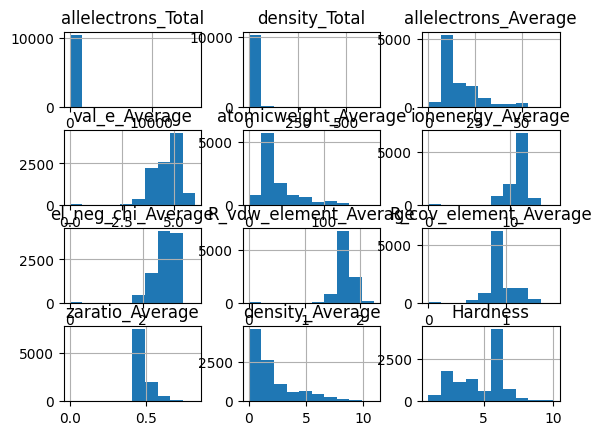

In [10]:
data.hist()

In [11]:
data.describe()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
count,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000
mean,128.053516,14.491342,17.033222,4.546789,37.507703,10.938308,2.607662,1.731330,0.944132,0.493349,2.132984,4.647126
std,224.123776,15.972877,10.468734,0.690864,26.012313,1.408276,0.334906,0.192481,0.180017,0.063080,1.936656,1.680525
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,68.000000,7.558488,10.000000,4.000000,20.298893,10.590660,2.530000,1.672500,0.864000,0.476196,0.814800,3.000000
50%,100.000000,10.650000,12.600000,4.714286,26.203827,11.202760,2.706000,1.732727,0.915556,0.488550,1.351550,5.500000
75%,131.000000,16.676996,22.000000,4.800000,48.719500,11.670725,2.805000,1.800000,0.981667,0.496070,2.741550,6.000000
max,15300.000000,643.093804,67.000000,6.000000,167.400000,15.245810,3.443000,2.250000,1.615840,0.825990,10.970000,10.000000


,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
allelectrons_Total,1.000000,0.616092,0.074725,0.071618,0.078489,0.034883,0.036897,0.038551,0.024420,0.031035,0.058067,-0.061687
density_Total,0.616092,1.000000,0.356399,0.083640,0.355614,-0.104870,-0.075535,0.202331,0.240787,-0.089792,0.336046,-0.161524
allelectrons_Average,0.074725,0.356399,1.000000,0.004376,0.990660,-0.360046,-0.319413,0.550669,0.688680,-0.328973,0.803641,-0.400496
val_e_Average,0.071618,0.083640,0.004376,1.000000,0.001860,0.453901,0.550007,0.354538,0.189352,0.093854,-0.068899,0.161715
atomicweight_Average,0.078489,0.355614,0.990660,0.001860,1.000000,-0.356640,-0.316053,0.529277,0.666165,-0.327459,0.796564,-0.402948
ionenergy_Average,0.034883,-0.104870,-0.360046,0.453901,-0.356640,1.000000,0.774050,0.078650,-0.235344,0.638616,-0.359735,0.203203
el_neg_chi_Average,0.036897,-0.075535,-0.319413,0.550007,-0.316053,0.774050,1.000000,0.121926,-0.174485,0.441195,-0.322099,0.290352
R_vdw_element_Average,0.038551,0.202331,0.550669,0.354538,0.529277,0.078650,0.121926,1.000000,0.811823,0.002984,0.439990,-0.061402
R_cov_element_Average,0.024420,0.240787,0.688680,0.189352,0.666165,-0.235344,-0.174485,0.811823,1.000000,-0.221164,0.571741,-0.189111
zaratio_Average,0.031035,-0.089792,-0.328973,0.093854,-0.327459,0.638616,0.441195,0.002984,-0.221164,1.000000,-0.306644,0.055248


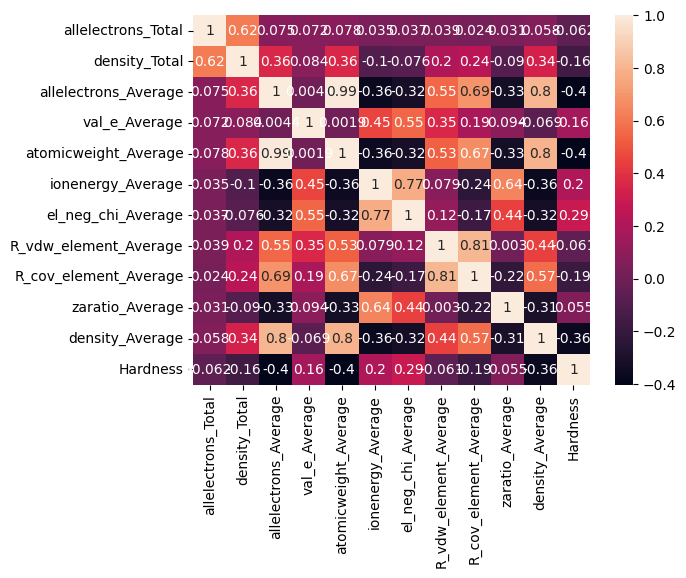

In [12]:
sns.heatmap(data.corr(), annot=True)
data.corr()

In [13]:
#data.drop(['atomicweight_Average', 'density_Average'], axis=1, inplace=True)
data.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
id,,,,,,,,,,,,
0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


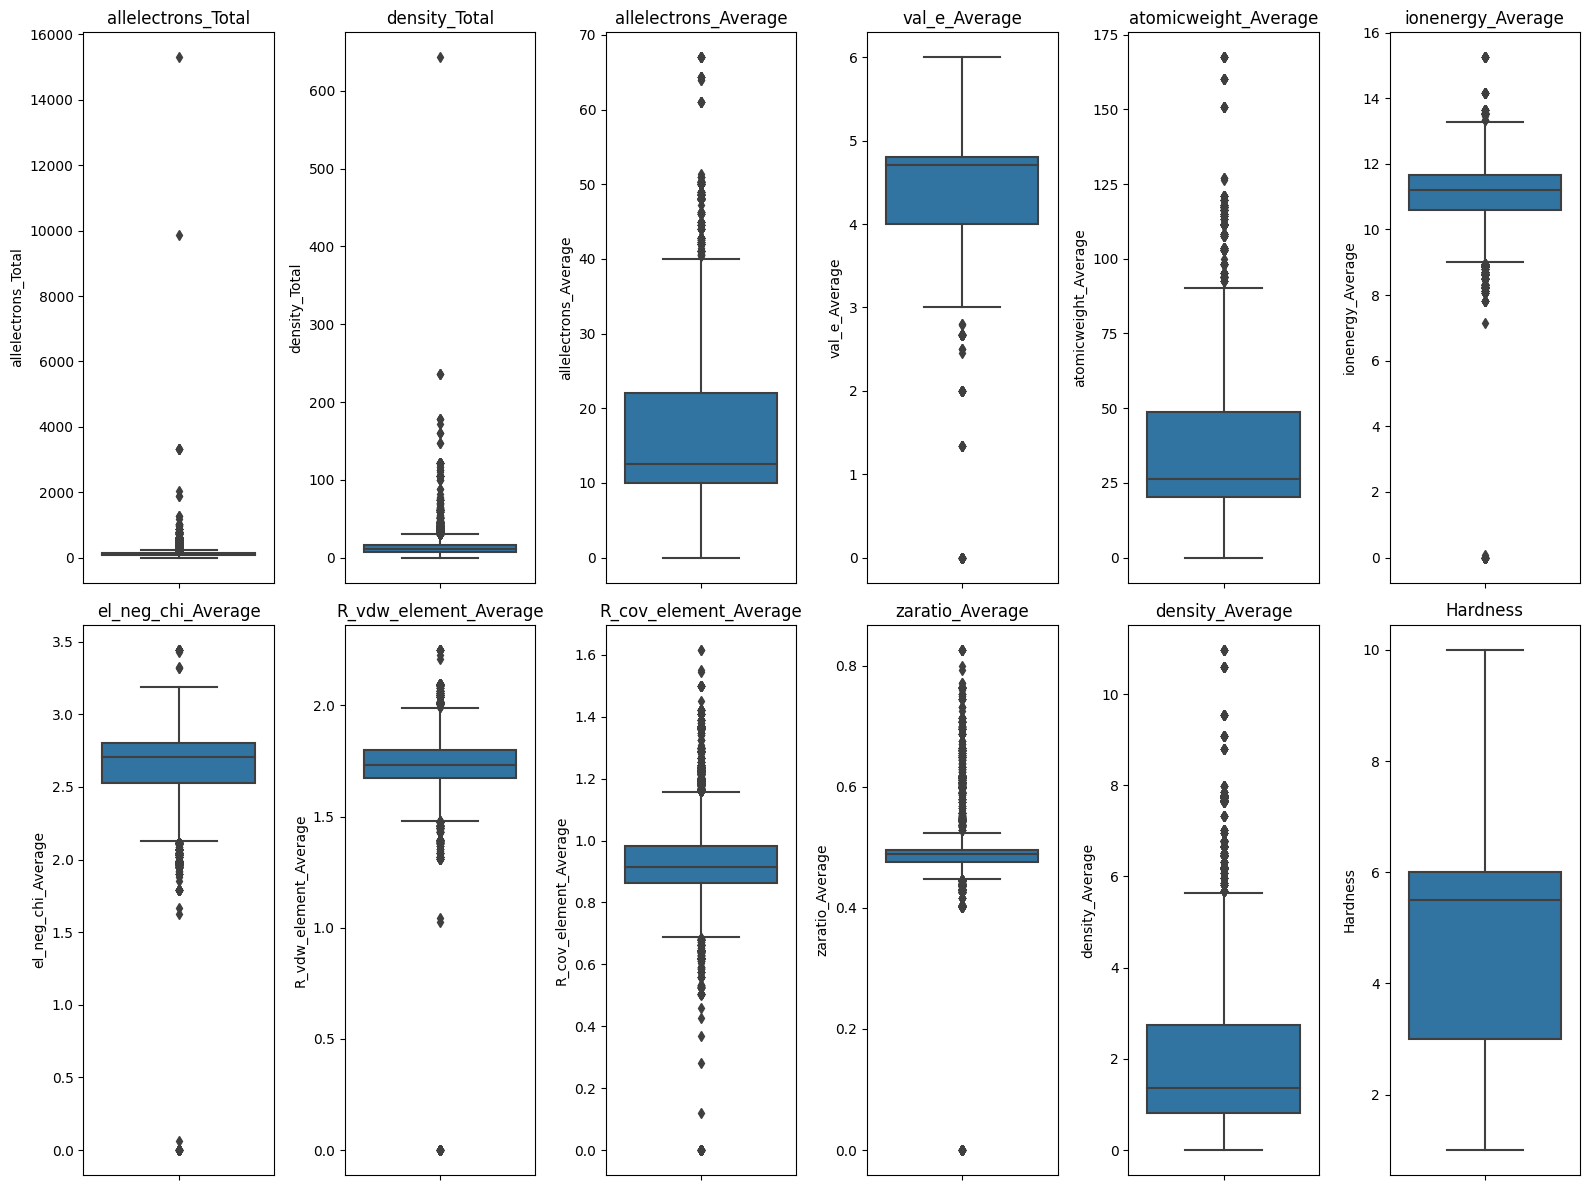

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 12))

# Loop through each column in the data
for i, column in enumerate(data.columns):
    # Create a subplot for each column
    # The arguments are (nrows, ncols, index)
    plt.subplot(2, 6, i+1)
    sns.boxplot(y=data[column])
    plt.title(column)

plt.tight_layout()  # Adjusts the layout
plt.show()

In [15]:
from scipy.stats.mstats import winsorize

#winsorize(data.allelectrons_Total, limits=0.025, inplace=True)
for i in data.columns.to_list():
  if (i!='Hardness'):
    winsorize(data[i], limits=0.05, inplace=True)

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X = data.iloc[:, :-1]
y = data.iloc[:, -1]
y.head()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [17]:
# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

# Convert the scaled arrays back into pandas DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [18]:
X_train_scaled.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
id,,,,,,,,,,,
2124,0.000000,0.000000,0.072464,0.873016,0.069232,1.000000,1.000000,0.090909,0.302030,0.192842,0.002263
394,0.115702,0.318773,0.449275,0.238095,0.487675,0.000000,0.204280,0.916928,0.982234,0.156854,0.713408
3101,0.252066,0.321407,0.134058,0.416667,0.119880,0.602273,0.582198,0.474922,0.465419,0.229676,0.219090
1737,0.475207,0.595459,1.000000,0.396825,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
561,0.392562,0.629218,0.285024,0.555556,0.286765,0.430241,0.619650,0.553292,0.505076,0.153132,0.240401


# Predicting

### 1 approach

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Making predictions
y_pred = model.predict(X_test_scaled)

# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')


MAE: 1.147347336059272
MSE: 2.063035478413511
RMSE: 1.436327079189664
R-squared: 0.240993118234209


In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Initialize models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'SVR': SVR(),
    'MLPRegressor': MLPRegressor()
}

# Train and evaluate models
results = {}
for name, model in models.items():
    # Train model
    model.fit(X_train_scaled, y_train)
    print(f'{name} trained.')

    # Predict on test set
    y_pred = model.predict(X_test_scaled)

    # Evaluate model
    results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': mean_squared_error(y_test, y_pred, squared=False),
        'R2': r2_score(y_test, y_pred)
    }

# Output results
for name, metrics in results.items():
    print(f'Results for {name}:')
    for metric, value in metrics.items():
        print(f'    {metric}: {value:.4f}')

# Hyperparameter tuning for Random Forest
parameters = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf_clf = GridSearchCV(RandomForestRegressor(), parameters, scoring='neg_mean_squared_error')
rf_clf.fit(X_train_scaled, y_train)

# Output best parameters and model
print(f'Best parameters for Random Forest: {rf_clf.best_params_}')
best_rf_model = rf_clf.best_estimator_

# Evaluate the best Random Forest model
best_rf_y_pred = best_rf_model.predict(X_test_scaled)
print(f'Random Forest - MAE: {mean_absolute_error(y_test, best_rf_y_pred)}')
print(f'Random Forest - MSE: {mean_squared_error(y_test, best_rf_y_pred)}')
print(f'Random Forest - RMSE: {mean_squared_error(y_test, best_rf_y_pred, squared=False)}')
print(f'Random Forest - R2: {r2_score(y_test, best_rf_y_pred)}')


LinearRegression trained.
Ridge trained.
Lasso trained.
DecisionTree trained.
RandomForest trained.
GradientBoosting trained.
SVR trained.


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor trained.
Results for LinearRegression:
    MAE: 1.1473
    MSE: 2.0630
    RMSE: 1.4363
    R2: 0.2410
Results for Ridge:
    MAE: 1.1475
    MSE: 2.0626
    RMSE: 1.4362
    R2: 0.2412
Results for Lasso:
    MAE: 1.4689
    MSE: 2.7183
    RMSE: 1.6487
    R2: -0.0001
Results for DecisionTree:
    MAE: 1.2318
    MSE: 3.1124
    RMSE: 1.7642
    R2: -0.1451
Results for RandomForest:
    MAE: 0.9295
    MSE: 1.5666
    RMSE: 1.2516
    R2: 0.4236
Results for GradientBoosting:
    MAE: 0.9243
    MSE: 1.5003
    RMSE: 1.2249
    R2: 0.4480
Results for SVR:
    MAE: 0.9394
    MSE: 1.7308
    RMSE: 1.3156
    R2: 0.3632
Results for MLPRegressor:
    MAE: 0.9864
    MSE: 1.6582
    RMSE: 1.2877
    R2: 0.3899


In [ ]:
import pandas as pd

# Step 1: Load the test data
test_data = pd.read_csv('test.csv')
test_data.drop(['atomicweight_Average', 'density_Average'], axis=1, inplace=True)

# Step 2: Preprocess and scale the test data
# (Assuming that 'id' is the first column and should not be scaled)
test_features = test_data.iloc[:, 1:]  # Exclude 'id' column
test_features_scaled = scaler.transform(test_features)  # Use the same scaler as before

# Step 3: Predict 'Hardness' using the best model
test_predictions = best_rf_model.predict(test_features_scaled)

# Step 4: Create a submission DataFrame
submission = pd.DataFrame({
    'id': test_data['id'],
    'Hardness': test_predictions
})

# Step 5: Save the predictions to a CSV file
submission.to_csv('submission.csv', index=False)

# Step 6: Submit the predictions to Kaggle
# kaggle competitions submit -c playground-series-s3e25 -f submission.csv -m "Message"

### 2 approach

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Define a parameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize the XGBoost regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', device='cuda')

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # You can choose a different scorer
    cv=5,
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV on the training data
grid_search.fit(X_train_scaled, y_train)

# Find the best parameters and the best estimator
best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f'Best parameters found: {best_parameters}')

# You can now evaluate the best_model on your test data and proceed with the predictions

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Assuming the scaler has been previously fitted on the training data
# and best_xgb_model is the best model obtained from GridSearchCV

# Step 1: Load the test data
test_data = pd.read_csv('test.csv')

# Optional: If you need to drop certain columns as per preprocessing done during training
#test_data.drop(['atomicweight_Average', 'density_Average'], axis=1, inplace=True)

# Step 2: Preprocess and scale the test data
# (Assuming that 'id' is the first column and should not be scaled)
test_features = test_data.iloc[:, 1:]  # Exclude 'id' column
test_features_scaled = scaler.transform(test_features)  # Use the same scaler as before

# Step 3: Predict 'Hardness' using the best XGBoost model
test_predictions = best_model.predict(test_features_scaled)

# Step 4: Create a submission DataFrame
submission = pd.DataFrame({
    'id': test_data['id'],  # Ensure this is the correct identifier column from your test set
    'Hardness': test_predictions
})

# Step 5: Save the predictions to a CSV file
submission.to_csv('xgb_submission_1.csv', index=False)

# The last step is to submit the predictions to Kaggle using the command line interface
# The command to submit to Kaggle would be run in your terminal, not in Python.
# Example command:
# kaggle competitions submit -c playground-series-s3e25 -f xgb_submission.csv -m "XGB Model Predictions"


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, median_absolute_error

# Make sure the training data is loaded and preprocessed (X_train_scaled, y_train)

# Step 1: Define the scorer based on Median Absolute Error
medae_scorer = make_scorer(median_absolute_error, greater_is_better=False)

# Step 2: Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Step 3: Initialize the GridSearchCV
xgb_model = XGBRegressor(objective='reg:squarederror', device='cuda')
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring=medae_scorer, cv=5, verbose=2)

# Step 4: Fit the GridSearchCV to the training data
grid_search.fit(X_train_scaled, y_train)

# Step 5: Print the best parameters and the best score
print(f'Best parameters found: {grid_search.best_params_}')
print(f'Best Median Absolute Error: {-grid_search.best_score_}')

# Step 6: Use the best estimator to make predictions on the test set
best_xgb_model = grid_search.best_estimator_

test_data = pd.read_csv('test.csv')

test_features = test_data.iloc[:, 1:]  # Exclude 'id' column
test_features_scaled = scaler.transform(test_features)  # Use the same scaler as before

test_predictions = best_xgb_model.predict(test_features_scaled)

# Create the submission DataFrame
submission = pd.DataFrame({
    'id': test_data['id'],  # Replace with the correct 'id' column from your test set
    'Hardness': test_predictions
})

# Save the submission file
submission.to_csv('xgb_submission.csv', index=False)

# Use the following command in your terminal to submit to Kaggle, not in Python
# kaggle competitions submit -c playground-series-s3e25 -f xgb_submission.csv -m "XGBRegressor with GridSearch"
